In [1]:
#%% Import

import os.path
import numpy as np
import pandas as pd
import scanpy as sc # v1.4.3
import sys
from statsmodels import robust
import matplotlib.pyplot as plt
from pygam import LogisticGAM
from scipy import sparse, io
import anndata
import scipy
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize
import pickle

/home/jovyan/my-conda-envs/py_env/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}




***Import healthy data***




In [2]:
os.chdir('/home/jovyan/data/bone_marrow/raw_data')
bm = sc.read_h5ad("full_bm.h5ad")

In [3]:
bm.obs = bm.obs[['Status', 'age', 'clusters_jan', 'batch', 'gender', 'n_genes', 'nUMI', 'percent.mito']]

In [4]:
bm = bm[~bm.obs['clusters_jan'].isin(['basophil', 'lymphoid_pre'])]

In [5]:
#bm = bm[bm.obs['clusters_jan'].isin(['myeloid_pre'])]

In [5]:
bm.var['mt'] = bm.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(bm, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Trying to set attribute `.var` of view, copying.


In [6]:
sc.pp.filter_cells(bm, min_genes=200)
sc.pp.filter_genes(bm, min_cells=3)

In [7]:
#Note ran this separately for Healthy and Downs
downs = bm[bm.obs.Status.isin(['Downs'])]
healthy = bm[bm.obs.Status.isin(['Healthy'])]

In [8]:
#Subsampled to 20% for healthy, ran all of Downs - so have roughly equal numbers of cells
sc.pp.subsample(healthy, fraction=0.1)
sc.pp.subsample(downs, fraction=0.5)

In [9]:
#bm = anndata.concat([healthy, downs], index_unique = None, join = 'outer')

In [10]:
bm.raw = bm
sc.pp.normalize_total(bm, target_sum=1e4)
sc.pp.log1p(bm)
sc.pp.highly_variable_genes(bm, min_mean=0.0125, max_mean=5, min_disp=0.5)
bm = bm[:, bm.var.highly_variable]

In [11]:
#make a dataframe of expression data

ex_matrix = pd.DataFrame(bm.raw.X.toarray())
ex_matrix.columns = bm.raw.var.index
ex_matrix.index = bm.obs.index



***PySCENIC of total data***



In [7]:
import os
import glob
import pickle
import pandas as pd
import numpy as np

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns


DATA_FOLDER="/home/jovyan/data/pySCENIC"
RESOURCES_FOLDER="/home/jovyan/data/pySCENIC/resources"
DATABASE_FOLDER = "/home/jovyan/data/pySCENIC/databases"
DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather")
DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "*.feather")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl")
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER, 'lambert2018.txt')
SC_EXP_FNAME = os.path.join(RESOURCES_FOLDER, "data.csv")
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs.csv")

In [8]:
ex_matrix = bm.to_df()

In [9]:
tf_names = load_tf_names(MM_TFS_FNAME)

In [10]:
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr"),
 FeatherRankingDatabase(name="hg38__refseq-r80__10kb_up_and_down_tss.mc9nr")]

In [ ]:
adjacencies = grnboost2(ex_matrix, tf_names=tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph


/home/jovyan/my-conda-envs/py_env/lib/python3.7/site-packages/arboreto/algo.py:214: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expression_matrix = expression_data.as_matrix()


6 partitions
computing dask graph


In [ ]:
adjacencies[adjacencies['TF'] == 'RUNX1']

In [ ]:
os.chdir('/home/jovyan/data/bone_marrow/data')
adjacencies.to_csv('adjacencies_bm_full.csv')

In [24]:
os.chdir('/home/jovyan/data/bone_marrow/data')
adjacencies = pd.read_csv('adjacencies_bm_equal_healthy_downs_210207.csv')

In [15]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))


2021-02-08 20:04:58,096 - pyscenic.utils - INFO - Calculating Pearson correlations.

2021-02-08 20:04:58,097 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.40s.  

In [16]:
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

[                                        ] | 0% Completed | 35.9s


2021-02-08 20:07:32,415 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.7s


2021-02-08 20:07:59,485 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  4.9s


2021-02-08 20:08:01,474 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 29.5s


2021-02-08 20:08:26,135 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 36.7s


2021-02-08 20:08:33,231 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF169 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 41.2s


2021-02-08 20:08:37,623 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 45.0s


2021-02-08 20:08:41,468 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  1min 56.6s


2021-02-08 20:08:53,618 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  2min  1.4s


2021-02-08 20:08:57,769 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF91 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  2min  2.8s


2021-02-08 20:08:59,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  2min  4.3s


2021-02-08 20:09:00,761 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min  7.0s


2021-02-08 20:09:03,452 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF215 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 11.3s


2021-02-08 20:09:07,781 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF235 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 12.0s


2021-02-08 20:09:08,569 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTERF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 12.4s


2021-02-08 20:09:08,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSRNP3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 12.7s


2021-02-08 20:09:09,186 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF251 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  2min 14.9s


2021-02-08 20:09:11,420 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  2min 18.5s


2021-02-08 20:09:14,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  2min 20.2s


2021-02-08 20:09:16,744 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF276 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  2min 21.7s


2021-02-08 20:09:18,157 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM15 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:09:18,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  2min 22.9s


2021-02-08 20:09:19,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  2min 27.7s


2021-02-08 20:09:24,183 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  2min 27.8s


2021-02-08 20:09:24,227 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  2min 28.5s


2021-02-08 20:09:25,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  2min 28.9s


2021-02-08 20:09:25,565 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  2min 29.7s


2021-02-08 20:09:26,241 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  2min 30.1s


2021-02-08 20:09:26,630 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF155 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  2min 30.9s


2021-02-08 20:09:27,428 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  2min 38.7s


2021-02-08 20:09:35,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  2min 41.4s


2021-02-08 20:09:37,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF382 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  2min 41.5s


2021-02-08 20:09:38,088 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF699 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  2min 41.7s


2021-02-08 20:09:38,127 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTERF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  2min 43.1s


2021-02-08 20:09:39,752 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSHZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  2min 44.1s


2021-02-08 20:09:40,659 - pyscenic.transform - WARNING - Less than 80% of the genes in SKI could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:09:40,764 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  2min 45.0s


2021-02-08 20:09:41,535 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF804A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  2min 45.9s


2021-02-08 20:09:42,580 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  2min 48.1s


2021-02-08 20:09:44,623 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  2min 49.2s


2021-02-08 20:09:45,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  2min 50.9s


2021-02-08 20:09:47,343 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL6B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  2min 52.7s


2021-02-08 20:09:49,260 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:09:49,320 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min 53.2s


2021-02-08 20:09:49,675 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min 53.3s


2021-02-08 20:09:50,658 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BORCS8-MEF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:09:50,820 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min 54.8s


2021-02-08 20:09:50,843 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:09:51,062 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF215 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:09:51,226 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min 55.0s


2021-02-08 20:09:51,422 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:09:51,456 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min 55.9s


2021-02-08 20:09:52,283 - pyscenic.transform - WARNING - Less than 80% of the genes in BORCS8-MEF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min 56.1s


2021-02-08 20:09:52,532 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF579 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min 57.1s


2021-02-08 20:09:53,521 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF584 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:09:53,539 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min 58.0s


2021-02-08 20:09:54,477 - pyscenic.transform - WARNING - Less than 80% of the genes in CC2D1A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min 58.6s


2021-02-08 20:09:55,086 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min 59.0s


2021-02-08 20:09:55,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:09:55,533 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min 59.1s


2021-02-08 20:09:55,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min 59.2s


2021-02-08 20:09:55,751 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB18 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min 59.5s


2021-02-08 20:09:55,982 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  3min  0.6s


2021-02-08 20:09:57,129 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  3min  0.8s


2021-02-08 20:09:57,356 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  3min  1.1s


2021-02-08 20:09:57,653 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  3min  2.1s


2021-02-08 20:09:58,694 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF619 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  3min  3.5s


2021-02-08 20:10:00,034 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF804A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  3min  6.7s


2021-02-08 20:10:03,092 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF502 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  3min  6.8s


2021-02-08 20:10:03,136 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF841 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:10:03,266 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  3min  7.2s


2021-02-08 20:10:03,826 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  3min  7.7s


2021-02-08 20:10:04,329 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  3min  8.4s


2021-02-08 20:10:04,962 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  3min  8.9s


2021-02-08 20:10:05,348 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:10:05,444 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  3min 10.4s


2021-02-08 20:10:06,979 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  3min 10.7s


2021-02-08 20:10:07,191 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  3min 11.7s


2021-02-08 20:10:08,256 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:10:08,359 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  3min 12.4s


2021-02-08 20:10:08,926 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF704 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  3min 14.4s


2021-02-08 20:10:10,953 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF11 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  3min 14.7s


2021-02-08 20:10:11,196 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 18% Completed |  3min 16.2s


2021-02-08 20:10:12,686 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 18% Completed |  3min 16.7s


2021-02-08 20:10:13,271 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 18% Completed |  3min 17.2s


2021-02-08 20:10:13,443 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  3min 17.5s


2021-02-08 20:10:13,975 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF382 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  3min 17.9s


2021-02-08 20:10:14,293 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:10:14,350 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF11 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 19.5s


2021-02-08 20:10:16,027 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 20.4s


2021-02-08 20:10:17,088 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  3min 20.9s


2021-02-08 20:10:17,356 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  3min 22.1s


2021-02-08 20:10:18,580 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  3min 22.4s


2021-02-08 20:10:18,953 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  3min 22.6s


2021-02-08 20:10:18,976 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  3min 23.3s


2021-02-08 20:10:19,923 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  3min 24.2s


2021-02-08 20:10:20,747 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  3min 24.6s


2021-02-08 20:10:21,098 - pyscenic.transform - WARNING - Less than 80% of the genes in TET1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  3min 25.5s


2021-02-08 20:10:22,086 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  3min 25.8s


2021-02-08 20:10:22,481 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:10:22,522 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  3min 26.2s


2021-02-08 20:10:22,607 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  3min 28.0s


2021-02-08 20:10:24,408 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  3min 28.7s


2021-02-08 20:10:25,148 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  3min 29.2s


2021-02-08 20:10:25,613 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  3min 29.4s


2021-02-08 20:10:25,959 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  3min 30.7s


2021-02-08 20:10:26,970 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  3min 31.2s


2021-02-08 20:10:27,737 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  3min 31.8s


2021-02-08 20:10:28,323 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  3min 32.4s


2021-02-08 20:10:28,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  3min 34.0s


2021-02-08 20:10:30,397 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:10:30,397 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  3min 34.2s


2021-02-08 20:10:30,734 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  3min 35.1s


2021-02-08 20:10:31,748 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  3min 35.5s


2021-02-08 20:10:32,045 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  3min 36.2s


2021-02-08 20:10:32,577 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  3min 36.4s


2021-02-08 20:10:32,834 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  3min 36.7s


2021-02-08 20:10:33,255 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF443 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  3min 37.0s


2021-02-08 20:10:33,487 - pyscenic.transform - WARNING - Less than 80% of the genes in REPIN1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  3min 37.5s


2021-02-08 20:10:34,001 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  3min 38.1s


2021-02-08 20:10:34,643 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF623 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  3min 38.5s


2021-02-08 20:10:34,961 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB34 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 40.4s


2021-02-08 20:10:36,937 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 40.6s


2021-02-08 20:10:37,084 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 41.2s


2021-02-08 20:10:37,752 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF660 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 42.3s


2021-02-08 20:10:38,800 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 43.1s


2021-02-08 20:10:39,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:10:39,722 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:10:39,677 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 44.0s


2021-02-08 20:10:40,567 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 44.6s


2021-02-08 20:10:41,140 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF804A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 46.0s


2021-02-08 20:10:42,556 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 46.5s


2021-02-08 20:10:42,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 47.9s


2021-02-08 20:10:44,644 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 48.4s


2021-02-08 20:10:44,897 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 48.5s


2021-02-08 20:10:45,033 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 48.9s


2021-02-08 20:10:45,718 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 49.7s


2021-02-08 20:10:46,221 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 50.0s


2021-02-08 20:10:46,496 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:10:46,632 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 51.1s


2021-02-08 20:10:47,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:10:49,545 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF91 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min 59.0s


2021-02-08 20:10:55,555 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  4min  2.6s


2021-02-08 20:10:59,152 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  4min  4.2s


2021-02-08 20:11:00,763 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 27% Completed |  4min  9.0s


2021-02-08 20:11:05,510 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 27% Completed |  4min  9.3s


2021-02-08 20:11:05,864 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  4min 10.0s


2021-02-08 20:11:06,507 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  4min 10.8s


2021-02-08 20:11:07,219 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP57 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  4min 10.9s


2021-02-08 20:11:07,450 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 32% Completed |  4min 19.0s


2021-02-08 20:11:15,525 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 32% Completed |  4min 19.5s


2021-02-08 20:11:15,918 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 20:11:15,959 - pyscenic.transform - WARNING - Less than 80% of the genes in SKI could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  4min 21.1s


2021-02-08 20:11:17,697 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  4min 23.0s


2021-02-08 20:11:19,424 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF112 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  4min 25.8s


2021-02-08 20:11:22,253 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF132 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  4min 29.7s


2021-02-08 20:11:26,220 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  4min 30.0s


2021-02-08 20:11:26,418 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  4min 40.7s


2021-02-08 20:11:37,138 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  4min 45.8s


2021-02-08 20:11:42,272 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  4min 50.3s


2021-02-08 20:11:48,067 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  4min 58.4s


2021-02-08 20:11:54,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF222 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  5min  7.6s


2021-02-08 20:12:04,038 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  5min 45.7s


2021-02-08 20:12:42,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################                        ] | 42% Completed |  5min 52.3s


2021-02-08 20:12:48,767 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  6min 11.1s


2021-02-08 20:13:07,545 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  6min 38.7s


2021-02-08 20:13:35,304 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###################                     ] | 47% Completed |  6min 39.4s


2021-02-08 20:13:35,889 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  6min 50.6s


2021-02-08 20:13:47,160 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  6min 52.1s


2021-02-08 20:13:48,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF91 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  6min 57.5s


2021-02-08 20:13:54,053 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  6min 59.6s


2021-02-08 20:13:56,092 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  7min  0.7s


2021-02-08 20:13:57,259 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  7min  4.2s

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

[#####################                   ] | 53% Completed |  7min  5.9s


2021-02-08 20:14:02,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  7min  9.1s


2021-02-08 20:14:05,726 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSRNP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  7min 10.5s


2021-02-08 20:14:07,029 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF215 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed |  7min 15.4s


2021-02-08 20:14:11,881 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed |  7min 16.3s


2021-02-08 20:14:12,867 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed |  7min 16.7s


2021-02-08 20:14:13,254 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed |  7min 18.3s


2021-02-08 20:14:14,874 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed |  7min 18.7s


2021-02-08 20:14:15,220 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed |  7min 20.2s


2021-02-08 20:14:17,937 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF235 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed |  7min 24.3s

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

[######################                  ] | 56% Completed |  7min 26.3s


2021-02-08 20:14:22,839 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF251 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 56% Completed |  7min 28.5s


2021-02-08 20:14:24,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 57% Completed |  7min 32.4s


2021-02-08 20:14:28,947 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 57% Completed |  7min 34.6s


2021-02-08 20:14:31,128 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 57% Completed |  7min 34.8s


2021-02-08 20:14:31,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed |  7min 36.2s


2021-02-08 20:14:32,852 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF276 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  7min 37.6s


2021-02-08 20:14:34,184 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  7min 38.2s


2021-02-08 20:14:34,883 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  7min 39.3s


2021-02-08 20:14:35,824 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  7min 39.5s


2021-02-08 20:14:35,981 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed |  7min 41.4s


2021-02-08 20:14:37,859 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed |  7min 41.5s


2021-02-08 20:14:38,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF155 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  7min 48.5s


2021-02-08 20:14:44,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  7min 48.9s


2021-02-08 20:14:45,355 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF382 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  7min 49.1s


2021-02-08 20:14:45,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF804A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  7min 50.6s


2021-02-08 20:14:47,030 - pyscenic.transform - WARNING - Less than 80% of the genes in SKI could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  7min 50.9s


2021-02-08 20:14:47,496 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  7min 52.7s


2021-02-08 20:14:49,288 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSHZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  7min 53.3s


2021-02-08 20:14:49,833 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  7min 56.0s


2021-02-08 20:14:52,462 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-08 20:14:52,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF215 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  7min 56.5s


2021-02-08 20:14:52,971 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  7min 56.6s


2021-02-08 20:14:53,065 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  7min 56.8s


2021-02-08 20:14:53,252 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL6B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  7min 58.9s


2021-02-08 20:14:55,330 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  7min 59.4s


2021-02-08 20:14:55,875 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  8min  0.2s


2021-02-08 20:14:56,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  8min  0.3s


2021-02-08 20:14:56,762 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF579 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  8min  1.2s


2021-02-08 20:14:57,688 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF584 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  8min  2.0s


2021-02-08 20:14:58,527 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BORCS8-MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  8min  2.1s


2021-02-08 20:14:58,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  8min  2.8s


2021-02-08 20:14:59,272 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  8min  2.9s


2021-02-08 20:14:59,523 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  8min  3.3s


2021-02-08 20:14:59,756 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  8min  3.4s


2021-02-08 20:14:59,879 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min  5.6s


2021-02-08 20:15:02,151 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF619 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min  7.8s


2021-02-08 20:15:04,258 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min  7.9s


2021-02-08 20:15:04,359 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min  8.1s


2021-02-08 20:15:04,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min  8.5s


2021-02-08 20:15:05,033 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min  9.0s


2021-02-08 20:15:05,581 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min  9.6s


2021-02-08 20:15:06,073 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 10.3s


2021-02-08 20:15:06,768 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 11.0s


2021-02-08 20:15:07,523 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF502 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 11.6s


2021-02-08 20:15:08,174 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 12.4s


2021-02-08 20:15:08,861 - pyscenic.transform - WARNING - Less than 80% of the genes in BORCS8-MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 12.5s


2021-02-08 20:15:08,977 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 12.6s


2021-02-08 20:15:09,052 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 13.0s


2021-02-08 20:15:09,563 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-08 20:15:09,618 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 16.1s


2021-02-08 20:15:12,638 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 16.2s


2021-02-08 20:15:12,740 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 16.4s


2021-02-08 20:15:12,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-08 20:15:12,774 - pyscenic.transform - WARNING - Less than 80% of the genes in CC2D1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 17.4s


2021-02-08 20:15:13,931 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 17.8s


2021-02-08 20:15:14,319 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 17.9s


2021-02-08 20:15:14,476 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF804A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 18.1s


2021-02-08 20:15:14,662 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF704 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 19.4s


2021-02-08 20:15:15,893 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 19.8s


2021-02-08 20:15:16,290 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 19.9s


2021-02-08 20:15:16,448 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF841 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 20.9s


2021-02-08 20:15:17,490 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 21.2s


2021-02-08 20:15:17,700 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 21.4s


2021-02-08 20:15:17,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-08 20:15:17,924 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF382 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-08 20:15:17,959 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 22.9s


2021-02-08 20:15:19,438 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  8min 24.2s


2021-02-08 20:15:20,703 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  8min 27.6s


2021-02-08 20:15:24,051 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-08 20:15:24,156 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  8min 28.5s


2021-02-08 20:15:24,629 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-08 20:15:24,700 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  8min 29.1s


2021-02-08 20:15:25,612 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  8min 30.3s


2021-02-08 20:15:26,796 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 70% Completed |  8min 32.5s


2021-02-08 20:15:28,998 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 70% Completed |  8min 34.3s


2021-02-08 20:15:30,732 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  8min 35.4s


2021-02-08 20:15:31,944 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  8min 36.1s


2021-02-08 20:15:32,662 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  8min 36.7s


2021-02-08 20:15:33,204 - pyscenic.transform - WARNING - Less than 80% of the genes in TET1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  8min 38.3s


2021-02-08 20:15:34,843 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  8min 38.8s


2021-02-08 20:15:35,272 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  8min 39.2s


2021-02-08 20:15:35,671 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-08 20:15:35,724 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  8min 40.0s


2021-02-08 20:15:36,700 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  8min 41.2s


2021-02-08 20:15:37,740 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  8min 41.8s


2021-02-08 20:15:38,255 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed |  8min 42.7s


2021-02-08 20:15:39,223 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 43.9s


2021-02-08 20:15:40,463 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 45.3s


2021-02-08 20:15:41,767 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 45.7s


2021-02-08 20:15:42,276 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 46.3s


2021-02-08 20:15:42,857 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 46.8s


2021-02-08 20:15:43,250 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 47.8s


2021-02-08 20:15:44,255 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 48.0s


2021-02-08 20:15:44,545 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 48.1s


2021-02-08 20:15:44,604 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 49.5s


2021-02-08 20:15:45,990 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-08 20:15:46,158 - pyscenic.transform - WARNING - Less than 80% of the genes in REPIN1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 49.9s


2021-02-08 20:15:46,425 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 50.2s


2021-02-08 20:15:46,677 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 50.6s


2021-02-08 20:15:46,874 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF443 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-08 20:15:47,121 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 51.3s


2021-02-08 20:15:47,838 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 53.4s


2021-02-08 20:15:49,866 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 53.7s


2021-02-08 20:15:50,359 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 54.1s


2021-02-08 20:15:50,571 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 54.2s


2021-02-08 20:15:50,681 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 54.7s


2021-02-08 20:15:51,337 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  8min 55.2s


2021-02-08 20:15:51,693 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  8min 55.9s


2021-02-08 20:15:52,470 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  8min 56.2s


2021-02-08 20:15:52,719 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF623 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  8min 56.7s


2021-02-08 20:15:53,226 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  8min 59.1s


2021-02-08 20:15:55,572 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB34 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  9min  2.7s


2021-02-08 20:15:59,253 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  9min  2.9s


2021-02-08 20:15:59,323 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF804A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  9min  3.1s


2021-02-08 20:15:59,652 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  9min  3.8s


2021-02-08 20:16:00,376 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  9min  4.1s


2021-02-08 20:16:00,725 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF660 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-08 20:16:01,389 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  9min  5.3s


2021-02-08 20:16:01,792 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  9min  5.9s


2021-02-08 20:16:02,521 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  9min  6.4s


2021-02-08 20:16:02,861 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  9min  7.2s


2021-02-08 20:16:03,682 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  9min  7.3s


2021-02-08 20:16:03,850 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  9min  9.6s


2021-02-08 20:16:06,030 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  9min 11.6s


2021-02-08 20:16:08,082 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  9min 11.7s


2021-02-08 20:16:08,229 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF91 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  9min 16.7s


2021-02-08 20:16:13,199 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  9min 21.1s


2021-02-08 20:16:17,643 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  9min 23.8s


2021-02-08 20:16:20,329 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  9min 24.0s


2021-02-08 20:16:20,417 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  9min 26.9s


2021-02-08 20:16:23,346 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP57 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  9min 27.0s


2021-02-08 20:16:23,606 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  9min 33.7s


2021-02-08 20:16:30,240 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  9min 34.2s


2021-02-08 20:16:30,774 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF112 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  9min 36.4s


2021-02-08 20:16:32,945 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF132 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  9min 40.1s


2021-02-08 20:16:36,652 - pyscenic.transform - WARNING - Less than 80% of the genes in SKI could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  9min 41.0s


2021-02-08 20:16:37,571 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  9min 52.5s


2021-02-08 20:16:49,026 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  9min 57.4s


2021-02-08 20:16:53,921 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF222 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 10min  1.5s


2021-02-08 20:16:58,043 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 10min  3.7s


2021-02-08 20:17:00,252 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 11min  6.0s


2021-02-08 20:18:02,477 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 11min 28.7s


2021-02-08 20:18:25,265 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################################] | 100% Completed | 11min 56.4s


In [17]:
regulons = df2regulons(df)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [25]:
#df.to_csv(MOTIFS_FNAME)
#with open(REGULONS_FNAME, "wb") as f:
#    pickle.dump(regulons, f)

In [27]:
#df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)


2021-02-08 18:00:06,548 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 18:00:13,770 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXC2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 18:00:13,901 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AIRE could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 18:00:13,949 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-08 18:00:14,196 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF4A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

20

In [18]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=4)

In [19]:
os.chdir('/home/jovyan/data/bone_marrow/data')
auc_mtx.to_csv('auc_mtx_myeloid_pre_only.csv')

In [22]:
#os.chdir('/home/jovyan/data/bone_marrow/data')
#adjacencies.to_csv('adjacencies_reduced.csv')

In [35]:
#sns.clustermap(auc_mtx, figsize=(8,8))

In [ ]:
#os.chdir('/home/ngr18/bone_marrow')
#total = sc.read_h5ad('total.h5ad')
#os.chdir('/home/ngr18/hcaskin/pySCENIC')


***Restart***



In [40]:
#os.chdir('/home/jovyan/data/bone_marrow/data')
#auc_mtx = pd.read_csv('full_mtx_bm_data.csv', index_col = 0)

In [ ]:
#os.chdir('/home/jovyan/data/bone_marrow/raw_data')
#bm = sc.read_h5ad("full_bm.h5ad")

In [ ]:
#bm.obs['combined'] = bm.obs['clusters_jan'].astype(str) + '_' + bm.obs['Status'].astype(str)

In [48]:
#full = pd.concat([bm.obs[['clusters_jan', 'Status']], auc_mtx], axis=1, join='inner')

In [49]:
#full.to_csv('full_mtx_bm_data_annotated.csv')

In [ ]:
bm.obs['combined'] = bm.obs['Status'].astype(str) + '_' + bm.obs['clusters_jan'].astype(str)

In [28]:
rss_cellType = regulon_specificity_scores(auc_mtx, bm.obs['clusters_jan'])

In [29]:
###calculate top regulons for each cluster
cats = sorted(list(set(bm.obs['clusters_jan'])))

topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:10].index)
    )
topreg = list(set(topreg))

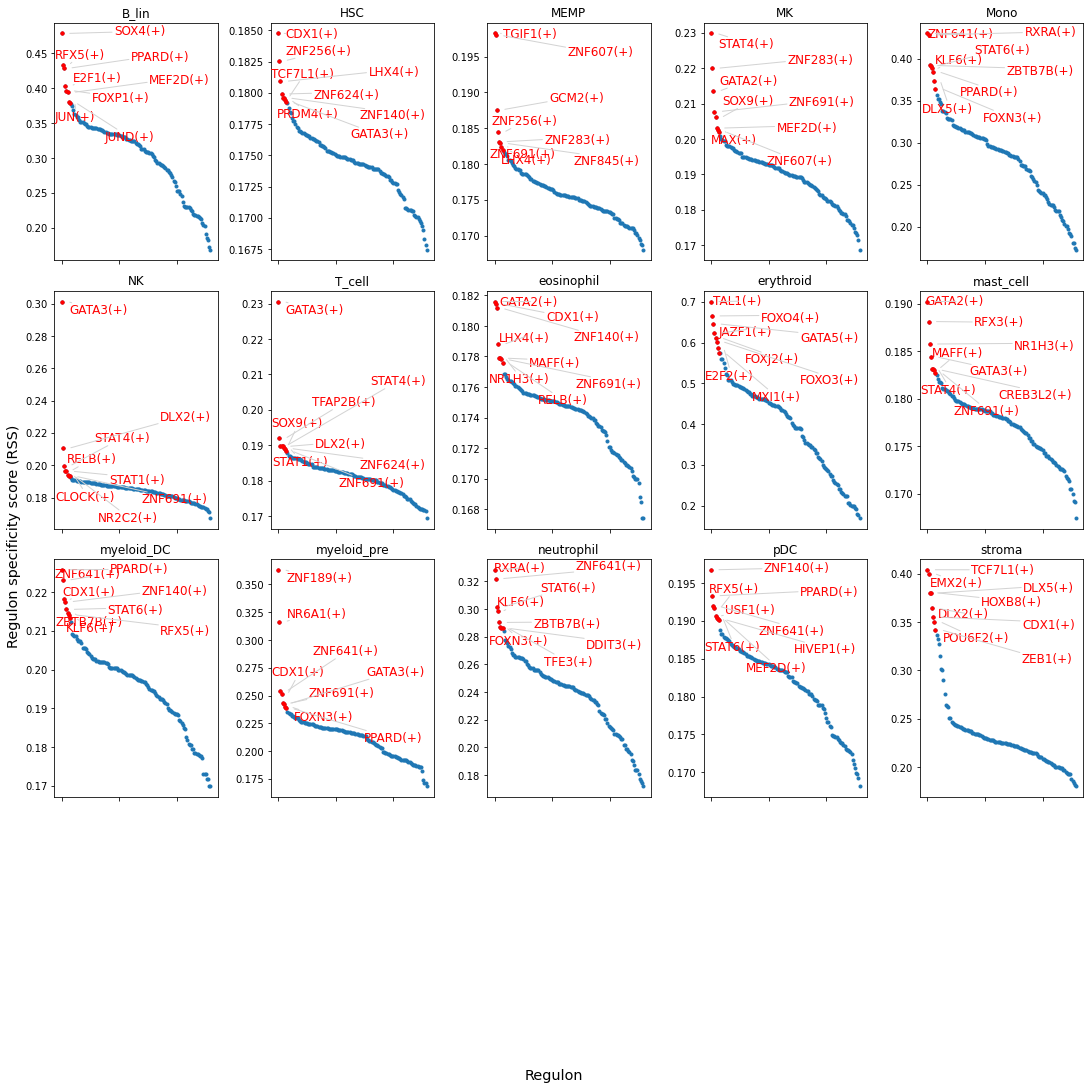

In [30]:
cats = sorted(list(set(bm.obs['clusters_jan'])))

fig = plt.figure(figsize=(15, 15))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(4,5,num)
    plot_rss(rss_cellType, c, top_n=8, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })

plt.show()

In [35]:
aucell_adata = sc.AnnData(X=auc_mtx.sort_index())
aucell_adata.obs = bm.obs

In [31]:
#save the subsetted data that you ran pySCENIC on

os.chdir('/home/jovyan/data/bone_marrow/data')
bm.write('bm_mix_data.h5ad')

... storing 'Status' as categorical
... storing 'age' as categorical
... storing 'batch' as categorical
... storing 'gender' as categorical


In [33]:
bm.obs = pd.concat([bm.obs, auc_mtx], axis=1, join='inner')

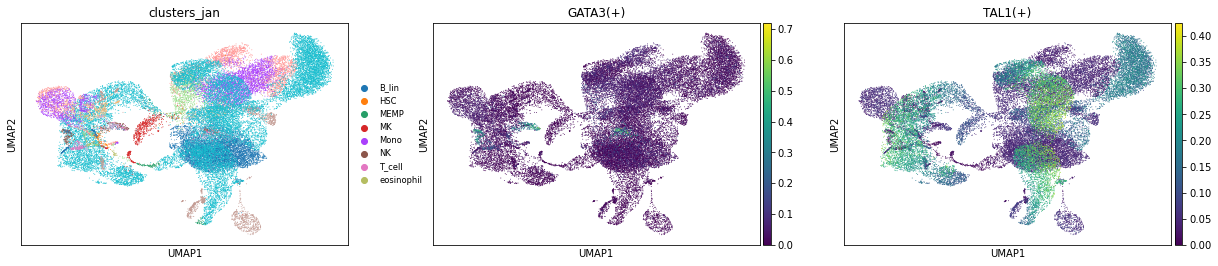

In [37]:
sc.pl.umap(bm, color=['clusters_jan', 'GATA3(+)', 'TAL1(+)'], legend_loc='right margin',legend_fontsize = 'small')